In [1]:
import cv2

import numpy as np
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt

np.random.seed(41)

In [2]:
# Plot formatting
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

Вспомогательные функции для чтения, записи и показа видео:

In [3]:
def show_video(filename):
    '''
    Press 'Q' to close video. Video closes automatically when done.
    '''
    cap = cv2.VideoCapture(filename)
    if (cap.isOpened() == False): 
        print("Error opening video")
 
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else: 
            break
 
    cap.release()
    cv2.destroyAllWindows()

In [4]:
def read_video_to_np(filename):
    frames = []
    cap = cv2.VideoCapture(filename)
    ret = True
    while ret:
        ret, img = cap.read() 
        if ret:
            frames.append(img)
    video = np.stack(frames, axis=0)

    return video

In [5]:
def write_video(video, filename):
    num_frames, height, width, _ = video.shape
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'DIVX'), fps=20, frameSize=(width, height))

    for frame in video:
        out.write(frame)
    out.release()

Загрузим исходное видео и разобьём его на две половины для построения двух фазовых траекторий:

In [6]:
video = read_video_to_np('walking_couple.mp4')
video_1 = video[:,:,:213,:]
video_2 = video[:,:,213:,:]

In [7]:
write_video(video_1, 'video_1.mp4')
write_video(video_2, 'video_2.mp4')

Построим одномерные траектории по каждому видео с помощью HOSVD (находим с помощью HOOI):

In [8]:
core, factors = tucker(video_1, (1, 10, 15, 3), verbose=True)

reconstruction error=13.531038723632332, variation=-0.00011263926133153745.
reconstruction error=13.53107391103606, variation=-3.518740372854268e-05.
converged in 3 iterations.


In [9]:
U_time_1 = factors[0][:,0]

In [10]:
core, factors = tucker(video_2, (1, 10, 15, 3), verbose=True)

reconstruction error=12.796092955252266, variation=-5.009024108915128e-05.
converged in 2 iterations.


In [11]:
U_time_2 = factors[0][:,0]

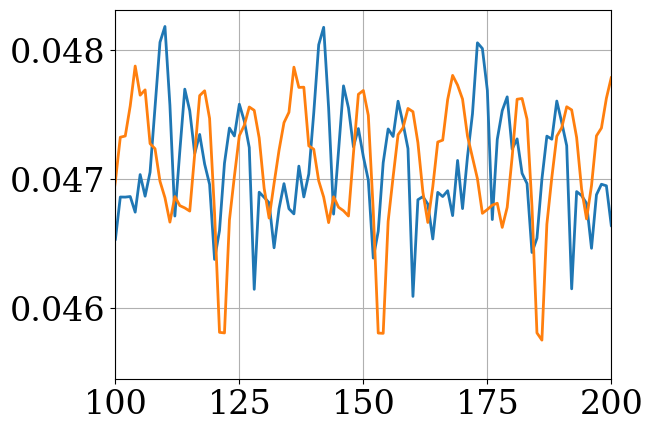

In [12]:
plt.plot(U_time_1)
plt.plot(U_time_2)

plt.grid()
plt.xlim((100, 200))

plt.savefig('fig/1D_trajectories.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

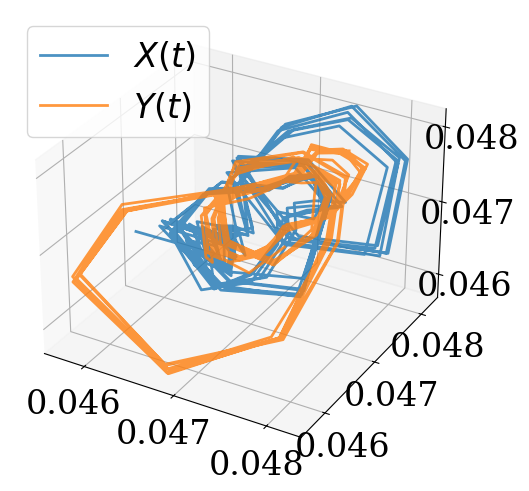

In [13]:
plt.subplots(subplot_kw={"projection": "3d"}, layout='constrained')

plt.plot(
    U_time_1[:200],
    U_time_1[1:201],
    U_time_1[2:202],
    alpha=0.8,
    label=r'$X(t)$'
)
plt.plot(
    U_time_2[:200],
    U_time_2[1:201],
    U_time_2[2:202],
    alpha=0.8,
    label=r'$Y(t)$'
)

plt.legend()

plt.savefig('fig/1D_phase_trajectories.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

Проанализируем на причинность с помощью CCM для одномерных рядов:

In [14]:
from causal_ccm.causal_ccm import ccm

In [15]:
corrs_1_to_2 = []
corrs_2_to_1 = []
L_range = range(3, len(U_time_1)+1)

for L in L_range:
    corrs_1_to_2.append(ccm(U_time_1, U_time_2, 1, 2, L).causality()[0])
    corrs_2_to_1.append(ccm(U_time_2, U_time_1, 1, 2, L).causality()[0])

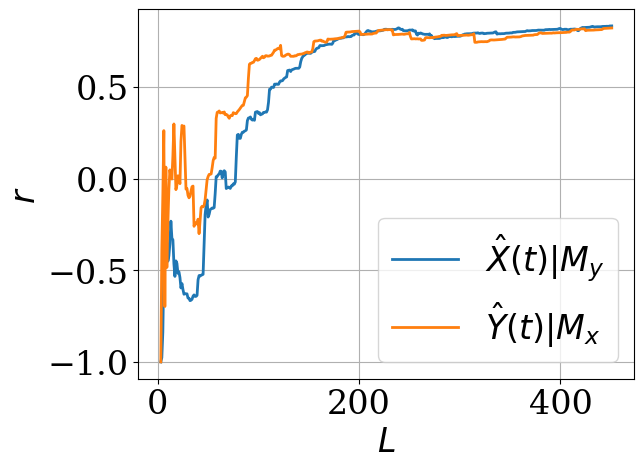

In [16]:
plt.plot(L_range, corrs_1_to_2, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, corrs_2_to_1, label='$\hat{Y}(t)|M_x$')

plt.xlabel(r'$L$')
plt.ylabel(r'$r$')
plt.grid()
plt.legend()

plt.savefig('fig/1D_causality.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

HOCCM?

In [17]:
core, factors = tucker(video_1, (3, 15, 15, 3), verbose=True)

reconstruction error=13.952365044966307, variation=-0.0003370649736371689.
reconstruction error=13.952422544034174, variation=-5.749906786789438e-05.
converged in 3 iterations.


In [18]:
HO_time_1 = factors[0]

In [19]:
core, factors = tucker(video_2, (3, 15, 15, 3), verbose=True)

reconstruction error=13.161743418527246, variation=-0.0003991891825876337.
reconstruction error=13.161823514045242, variation=-8.009551799581516e-05.
converged in 3 iterations.


In [20]:
HO_time_2 = factors[0]

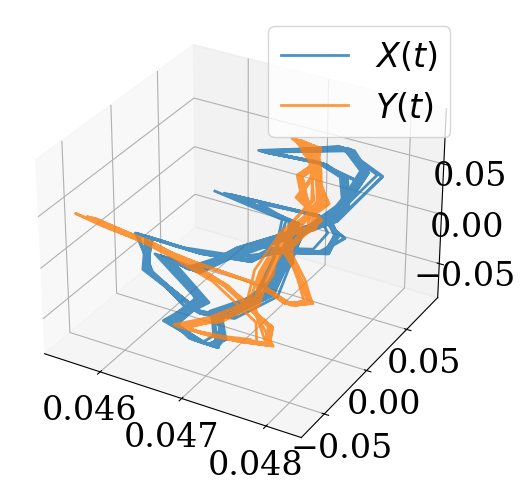

In [21]:
plt.subplots(subplot_kw={"projection": "3d"}, layout='constrained')

plt.plot(
    HO_time_1[:,0],
    HO_time_1[:,1],
    HO_time_1[:,2],
    alpha=0.8,
    label=r'$X(t)$'
)
plt.plot(
    HO_time_2[:,0],
    HO_time_2[:,1],
    HO_time_2[:,2],
    alpha=0.8,
    label=r'$Y(t)$'
)

plt.legend()

plt.savefig('fig/3D_trajectories.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

Перепишем класс `ccm` для работы с высокими размерностями:

In [22]:
def Pearson_corr(X, Y):
    delta_X = np.array([X_i - np.mean(X, axis=0) for X_i in X])
    delta_Y = np.array([Y_i - np.mean(Y, axis=0) for Y_i in Y])
    norms = np.linalg.norm(delta_X) * np.linalg.norm(delta_Y)
    
    return sum([np.dot(dx, dy) for dx, dy in zip(delta_X, delta_Y)]) / norms

class hoccm(ccm):
    # get pairwise distances between vectors in X
    def get_distances(self, Mx):
        """
        Args
            Mx: The shadow manifold from X
        Returns
            t_steps: timesteps
            dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
        """

        # we extract the time indices and vectors from the manifold Mx
        # we just want to be safe and convert the dictionary to a tuple (time, vector)
        # to preserve the time inds when we separate them
        t_vec = [(k, v) for k,v in Mx.items()]
        t_steps = np.array([i[0] for i in t_vec])
        vecs = np.array([i[1] for i in t_vec])
        dists = np.array([[np.linalg.norm(vec_1 - vec_2) for vec_1 in vecs] for vec_2 in vecs])
        return t_steps, dists

    def predict(self, t):
        """
        Args
            t: timestep at Mx to predict Y at same time step
        Returns
            Y_true: the true value of Y at time t
            Y_hat: the predicted value of Y at time t using Mx
        """
        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
    
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)
    
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor.T).sum(axis=1) # get X_hat
    
        return X_true, X_hat

    def causality(self):
        '''
        Args:
            None
        Returns:
            correl: how much self.X causes self.Y. correlation between predicted Y and true Y
        '''

        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y        
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = np.array(X_true_list), np.array(X_hat_list)
        r = Pearson_corr(x, y)       

        return r

In [23]:
from tqdm import tqdm

HO_corrs_1_to_2 = []
HO_corrs_2_to_1 = []
L_range = range(3, 100)

for L in tqdm(L_range):
    HO_corrs_1_to_2.append(hoccm(HO_time_1, HO_time_2, 1, 2, L).causality())
    HO_corrs_2_to_1.append(hoccm(HO_time_2, HO_time_1, 1, 2, L).causality())

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 34.54it/s]


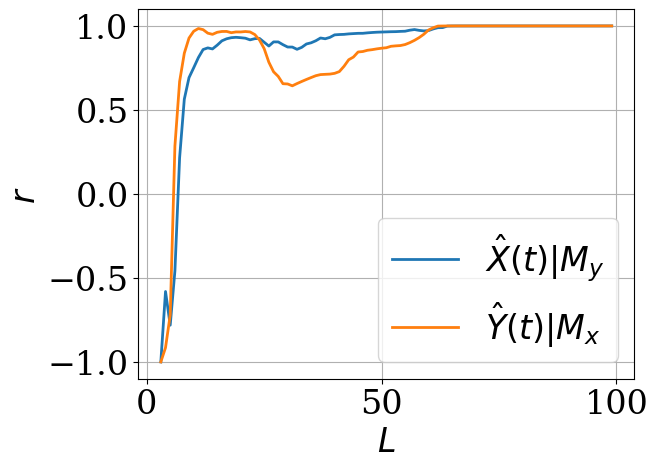

In [24]:
plt.plot(L_range, HO_corrs_1_to_2, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, HO_corrs_2_to_1, label='$\hat{Y}(t)|M_x$')

plt.xlabel(r'$L$')
plt.ylabel(r'$r$')
plt.grid()
plt.legend()

plt.savefig('fig/3D_causality.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

Попробуем использовать ещё большую размерность траектории:

In [25]:
core, factors = tucker(video_1, (10, 15, 15, 3), verbose=True)

reconstruction error=14.283299336437123, variation=-9.98175088753328e-05.
converged in 2 iterations.


In [26]:
EHO_time_1 = factors[0]

In [27]:
core, factors = tucker(video_2, (10, 15, 15, 3), verbose=True)

reconstruction error=13.350411030801162, variation=-2.682052454794359e-05.
converged in 2 iterations.


In [28]:
EHO_time_2 = factors[0]

In [29]:
from tqdm import tqdm

EHO_corrs_1_to_2 = []
EHO_corrs_2_to_1 = []
L_range = range(3, 100)

for L in tqdm(L_range):
    EHO_corrs_1_to_2.append(hoccm(EHO_time_1, EHO_time_2, 1, 2, L).causality())
    EHO_corrs_2_to_1.append(hoccm(EHO_time_2, EHO_time_1, 1, 2, L).causality())

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 36.47it/s]


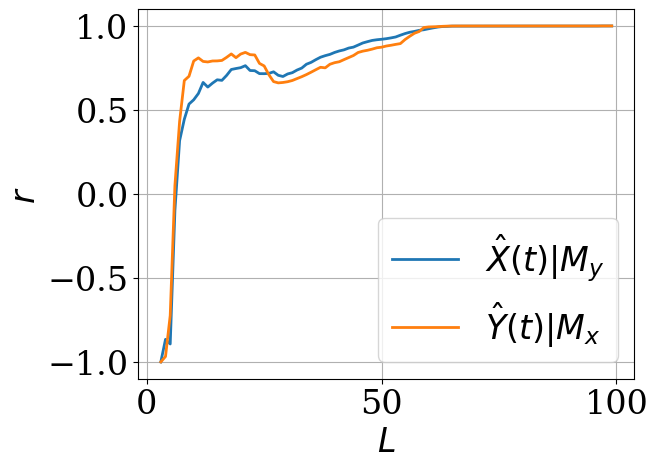

In [30]:
plt.plot(L_range, EHO_corrs_1_to_2, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, EHO_corrs_2_to_1, label='$\hat{Y}(t)|M_x$')

plt.xlabel(r'$L$')
plt.ylabel(r'$r$')
plt.grid()
plt.legend()

plt.savefig('fig/10D_causality.png', bbox_inches='tight', pad_inches=0.1)

plt.show()